## **Project: Car Evaluation Model**
- **Source**: M. Bohanec, V. Rajkovič (1988). Knowledge acquisition and explanation for multi-attribute decision making. Published in 8th Intl Workshop on Expert Systems and their Applications, Avignon, France
- **URL**: https://archive.ics.uci.edu/dataset/19/car+evaluation
- **Date**: 10/01/24
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
# Step 0. Import libraries and custom modules
# Basics ---------------------------------------------------------------
import logging
import pickle
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder
)
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    matthews_corrcoef,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
import shap

def bootstrap_model(model, X, y, X_test, y_test, 
                    n_bootstraps=300, type='clf'):
    if type == 'clf':
        # Classification
        accuracy_scores = []
        cohen_kappa_scores = []
    result = {}
    for _ in range(n_bootstraps):
        idx = np.random.choice(len(X), size=len(X), replace=True)
        X_boot, y_boot = X.reindex(idx), y[idx]
        model.fit(X_boot, y_boot)
        y_temp = model.predict(X_test)
        if type == 'clf':
            accuracy_scores.append(
                accuracy_score(y_test, y_temp)
            )
            cohen_kappa_scores.append(
                cohen_kappa_score(y_test, y_temp)
            )
    if type == 'clf':
        result = {'ACCURACY': accuracy_scores, 
                  'COHEN_KAPPA': cohen_kappa_scores}
    return result

# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
df_raw = pd.read_csv('../../data/car.csv', header=None)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1728 non-null   object
 1   1       1728 non-null   object
 2   2       1728 non-null   object
 3   3       1728 non-null   object
 4   4       1728 non-null   object
 5   5       1728 non-null   object
 6   6       1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [3]:
df_raw.sample(10, random_state=2024)

,0,1,2,3,4,5,6
133,vhigh,high,2,more,big,med,unacc
1221,med,low,3,2,big,low,unacc
209,vhigh,high,5more,more,small,high,unacc
159,vhigh,high,3,more,big,low,unacc
1091,med,med,2,4,small,high,acc
1628,low,low,2,2,big,high,unacc
134,vhigh,high,2,more,big,high,unacc
63,vhigh,vhigh,4,4,small,low,unacc
918,med,vhigh,4,2,small,low,unacc
47,vhigh,vhigh,3,more,small,high,unacc


##### **Data dictionary**
|Name|Description|Type|Units|
|----|-----------|----|-----|
|buying|buying price|Category|vhigh, high, med, low|
|maint|price of the maintenance|Category|vhigh, high, med, low|
|doors|number of doors|Category|2, 3, 4, 5more|
|persons|capacity in terms of persons to carry|Category|2, 4, more|
|lug_boot|the size of luggage boot|Category|small, med, big|
|safety|estimated safety of the car|Category|low, med, high|
|class|evaulation level|Category|unacc, acc, good, vgood|

### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
df_baking = df_raw.copy()
df_baking.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df_baking = df_baking.astype(
    {'buying': 'category',
     'maint': 'category',
     'doors': 'category',
     'persons': 'category',
     'lug_boot': 'category',
     'safety': 'category',
     'class': 'category'}
)
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   buying    1728 non-null   category
 1   maint     1728 non-null   category
 2   doors     1728 non-null   category
 3   persons   1728 non-null   category
 4   lug_boot  1728 non-null   category
 5   safety    1728 non-null   category
 6   class     1728 non-null   category
dtypes: category(7)
memory usage: 13.1 KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [5]:
df_train, df_test = train_test_split(
    df, test_size=0.2,
    stratify=df['class'],
    random_state=2024
)
df_train, df_val = train_test_split(
    df_train, test_size=0.2,
    stratify=df_train['class'],
    random_state=2024
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((1105, 7), (277, 7), (346, 7))

In [6]:
df_train.describe(include='category').T

,count,unique,top,freq
buying,1105,4,low,285
maint,1105,4,med,284
doors,1105,4,5more,287
persons,1105,3,4,380
lug_boot,1105,3,med,370
safety,1105,3,low,372
class,1105,4,unacc,774


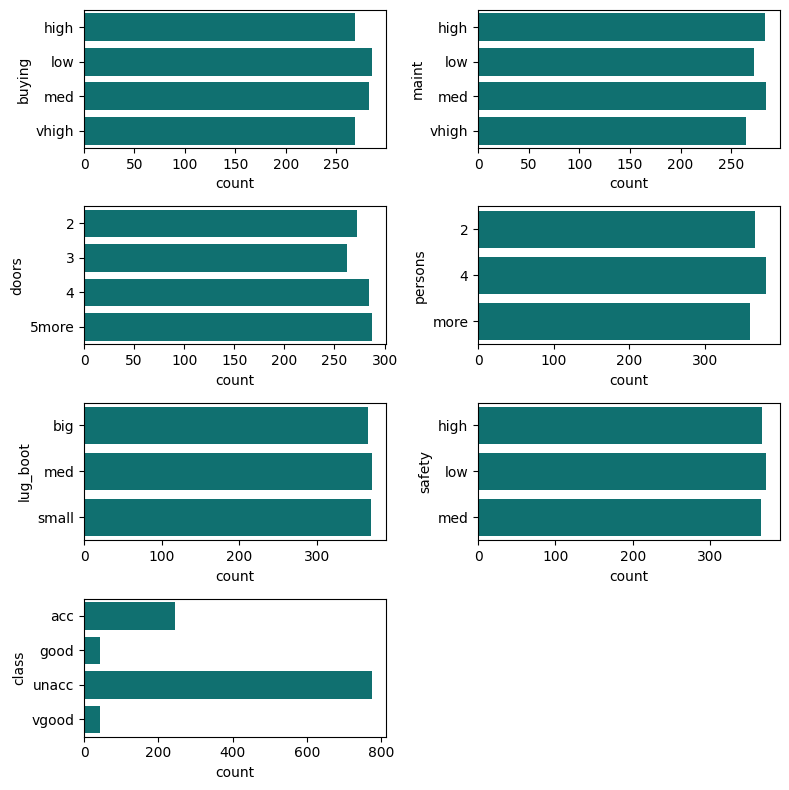

In [7]:
# Univariate analysis
fig, ax = plt.subplots(4,2, figsize=(8,8))
axes = ax.flatten()
for i, ax in enumerate(axes):
    if i<df_train.shape[1]:
        sns.countplot(df_train.iloc[:,i], color='Teal', ax=ax)
    else:
        axes[-1].remove()
plt.tight_layout()
plt.show()

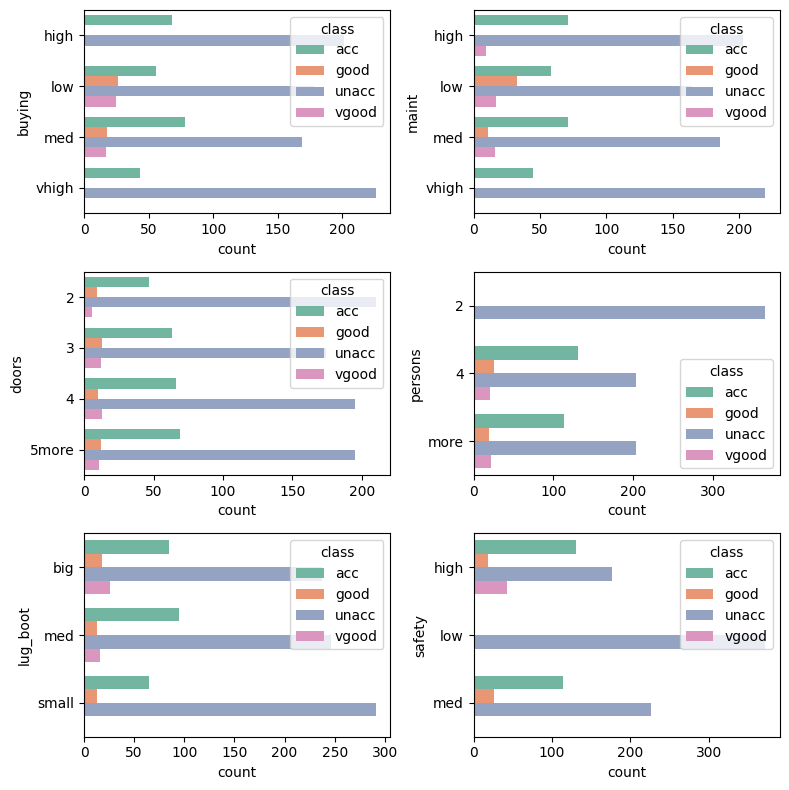

In [8]:
# Bivariate analysis
fig, ax = plt.subplots(3,2, figsize=(8,8))
axes = ax.flatten()
cols = df_train.columns.to_list()
for i, ax in enumerate(axes):
    if i<df_train.shape[1]:
        sns.countplot(df_train, y=cols[i], hue=cols[-1], ax=ax, palette='Set2')
plt.tight_layout()
plt.show()

### **4. Machine learning**
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [9]:
X_train = df_train.drop(columns=['class'])
y_train = df_train['class']
X_val = df_val.drop(columns=['class'])
y_val = df_val['class']
X_test = df_test.drop(columns=['class'])
y_test = df_test['class']

In [10]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [11]:
clf_rforest_p = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('rforest', RandomForestClassifier(class_weight='balanced'))
])

clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        'rforest__n_estimators': [10, 20, 30, 50, 100, 200, 300],
        'rforest__max_depth': [None, 2,3,4,5,6,7],
    },
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

In [12]:
clf_rforest_cv.fit(X_train, y_train_enc)
clf_rforest_cv.best_params_

{'rforest__max_depth': None, 'rforest__n_estimators': 200}


##### Clasification Metrics ######
- Accuracy: 0.96
- Cohen Kappa: 0.92
- Matthews correlation: 0.92
##################################

              precision    recall  f1-score   support

         acc       0.89      0.95      0.92        62
        good       1.00      0.82      0.90        11
       unacc       0.99      0.97      0.98       194
       vgood       0.91      1.00      0.95        10

    accuracy                           0.96       277
   macro avg       0.95      0.94      0.94       277
weighted avg       0.97      0.96      0.96       277



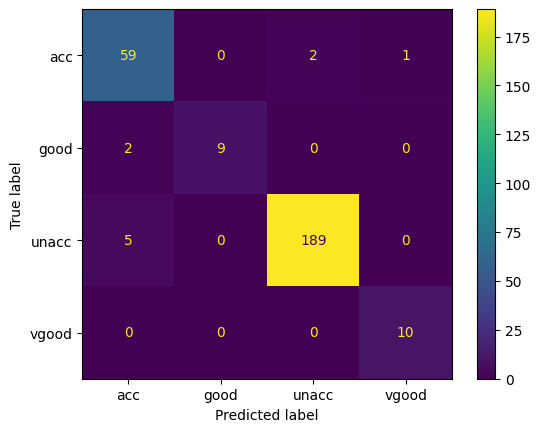

In [13]:
y_hat_val = clf_rforest_cv.best_estimator_.predict(X_val)
classification_metrics = f"""
##### Clasification Metrics ######
- Accuracy: {accuracy_score(y_val_enc, y_hat_val):.2f}
- Cohen Kappa: {cohen_kappa_score(y_val_enc, y_hat_val):.2f}
- Matthews correlation: {matthews_corrcoef(y_val_enc, y_hat_val):.2f}
##################################
"""
print(classification_metrics)
print(classification_report(
    y_val_enc, y_hat_val, 
    target_names=label_encoder.classes_)
)
ConfusionMatrixDisplay.from_predictions(
    y_val_enc, y_hat_val, 
    display_labels=label_encoder.classes_
)
plt.show()

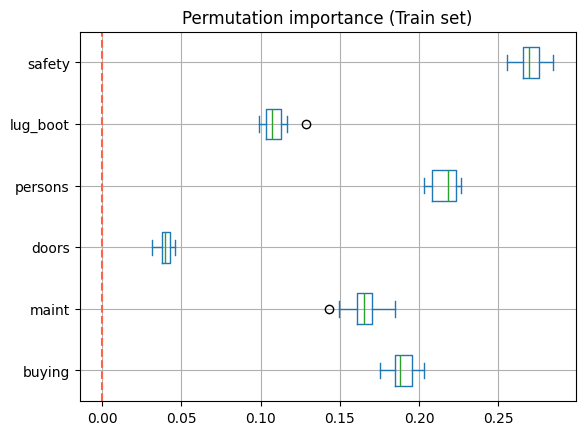

In [14]:
importance = permutation_importance(
    clf_rforest_cv, X_train, y_train_enc, 
    n_repeats=25, random_state=2024
)
importance_df = pd.DataFrame(
    importance.importances.T, 
    columns=X_train.columns
)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--', c='Tomato')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()

In [15]:
X_encoded = clf_rforest_cv.best_estimator_['onehot'].fit_transform(X_train)
features = clf_rforest_cv.best_estimator_['onehot'].get_feature_names_out()
best_model = clf_rforest_cv.best_estimator_['rforest'].fit(X_encoded, y_train_enc)

# calculate the Shap values
shap_values = shap.TreeExplainer(best_model).shap_values(pd.DataFrame(X_encoded.toarray(),columns=features))

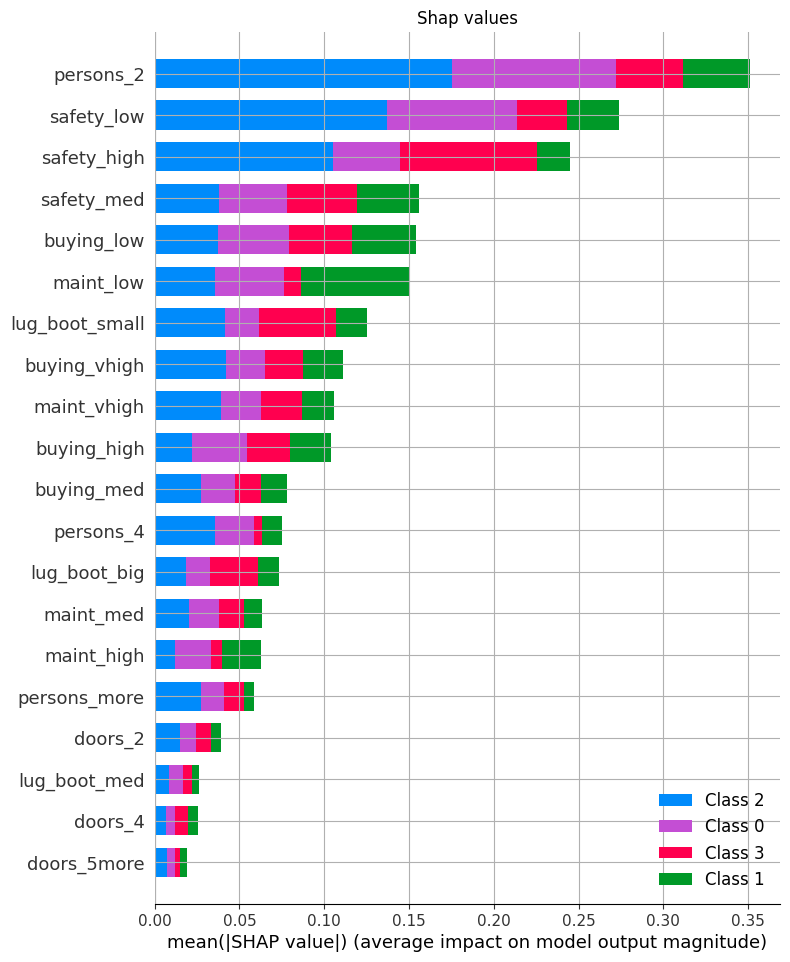

In [16]:
plt.figure()
shap.summary_plot(
    shap_values, pd.DataFrame(X_encoded.toarray(),columns=features), 
    plot_type='bar', show=False)
plt.title('Shap values')
plt.grid(True)
plt.show()

In [17]:
result = bootstrap_model(
    clf_rforest_cv, X_train, y_train_enc, X_test, y_test_enc,
    n_bootstraps=25, type='clf'
)

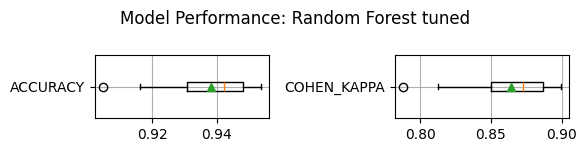

ACCURACY mean: 0.94, CI: (0.91 - 0.95)
COHEN KAPPA mean: 0.86, CI: (0.80 - 0.90)


In [18]:
fig, ax = plt.subplots(1,2, figsize=(6,1.5))
ax[0].boxplot(x=result['ACCURACY'], vert=False, showmeans=True)
ax[0].grid(True)
ax[0].set_yticks([1],['ACCURACY'])
ax[1].boxplot(x=result['COHEN_KAPPA'], vert=False, showmeans=True)
ax[1].grid(True)
ax[1].set_yticks([1],['COHEN_KAPPA'])
plt.suptitle('Model Performance: Random Forest tuned')
plt.tight_layout()
plt.show()
ci_low_acc, ci_high_acc = np.percentile(result['ACCURACY'], [2.5, 97.5])
ci_low_ck, ci_high_ck = np.percentile(result['COHEN_KAPPA'], [2.5, 97.5])
print(f'ACCURACY mean: {np.mean(result["ACCURACY"]):.2f}, CI: ({ci_low_acc:.2f} - {ci_high_acc:.2f})')
print(f'COHEN KAPPA mean: {np.mean(result["COHEN_KAPPA"]):.2f}, CI: ({ci_low_ck:.2f} - {ci_high_ck:.2f})')

In [19]:
final_model_p = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('rforest', RandomForestClassifier(
        class_weight='balanced',
        max_depth=None,
        n_estimators=50))
])
final_model_p.fit(X_train, y_train_enc)
y_hat = final_model_p.predict(X_test)
classification_metrics = f"""
######### Final Metrics ##########
- Accuracy: {accuracy_score(y_test_enc, y_hat):.2f}
- Cohen Kappa: {cohen_kappa_score(y_test_enc, y_hat):.2f}
- Matthews correlation: {matthews_corrcoef(y_test_enc, y_hat):.2f}
##################################
"""
print(classification_metrics)


######### Final Metrics ##########
- Accuracy: 0.95
- Cohen Kappa: 0.89
- Matthews correlation: 0.89
##################################



### 5. Model saving
**Objective**: Save the model and some critical information we consider necessary

In [20]:
# Step 5. Save the model for further usage
# 5.1 Create model dictionary
cats = {X_train.columns.to_list()[i]: list(el.categories) 
        for i, el in enumerate(X_train.dtypes.to_list())}
model_dict = {
    'model': clf_rforest_cv,
    'algorithm_name': 'Random Forest Classifier',
    'predictors': X_train.columns.to_list(),
    'predictor_types': list(X_train.dtypes.astype(str)),
    'predictor_categories': cats,
    'target_name': y_train.name,
    'target_classes': label_encoder.classes_,
    'metrics': 'Accuracy=0.96, Worst recall=0.90(Good)'
}

In [21]:
try:
    with open('../../models/car_evaluation_model.pkl','wb') as file:
        pickle.dump(model_dict, file)
    print('Save succesful')
except Exception as e:
    print(f'Could not save the file: {e}')

Save succesful
